# A Monte Carlo simulation technique to determine the optimal portfolio - <br> `Hassan Ghodrati and Zahra Zahiri`

Objective : Determine asset allocation using Monte Carlo simulation and the weight of optimal investment is determined using a hybrid model called Markowitz and Winker model. 

### Calculating VaR using Monte Carlo Simulations

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf 
from datetime import datetime, timedelta
import statsmodels.api as sm 
from scipy.stats import skew, kurtosis 
from scipy.optimize import minimize  

plt.style.use('seaborn-v0_8-dark-palette') 
import warnings
warnings.filterwarnings('ignore') 

#### 1. Fetch Data

In [2]:
start_date = '2011-01-01' 
end_date = '2019-12-30' 

tickers = ['AAPL','AMD','NVDA','MSFT','TSLA','AMZN']  

In [3]:
data = pd.DataFrame() 
data = yf.download(tickers,start=start_date,end=end_date)['Adj Close'] 
data.head(3) 

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,AMD,AMZN,MSFT,NVDA,TSLA
Date,,,,,,
2011-01-03,9.951282,8.47,9.2110,21.585318,0.362763,1.774667
2011-01-04,10.003216,8.77,9.2505,21.670177,0.361617,1.778000
2011-01-05,10.085043,8.91,9.3710,21.600742,0.389363,1.788667


#### 2. Calculate Daily Log Returns

In [4]:
log_returns = np.log(data/data.shift(1)).dropna() 
log_returns.head(3) 

Ticker,AAPL,AMD,AMZN,MSFT,NVDA,TSLA
Date,,,,,,
2011-01-04,0.005205,0.034806,0.004279,0.003924,-0.003166,0.001876
2011-01-05,0.008147,0.015837,0.012942,-0.003209,0.073927,0.005981
2011-01-06,-0.000809,-0.025001,-0.008358,0.028865,0.129622,0.038389


#### 3. Defining number of simulations and Time Horizon

In [5]:
num_sims = 1000
time_horizon = 10    # One day

confidence_level = 0.95 

#### 4. Calculating VaR for each stock using Monte Carlo Simulation

In [6]:
np.random.seed(42) 
VaRs={} 
data_sim = pd.DataFrame() 
for tick in tickers: 
    data_tick = pd.DataFrame() 
    mean_return = log_returns[tick].mean() 
    std_return = log_returns[tick].std() 
    
    # Simulate Future Returns using Monte Carlo
    simulated_returns = np.random.normal(mean_return,std_return,num_sims*10).reshape(num_sims,10) 

    data_tick = pd.DataFrame(simulated_returns)
    data_sim[tick] = data_tick.iloc[:,-1] 

    # Calculate VaR
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    VaRs[tick] = -VaR.round(2) 

# Output VaRs for each stock
for tick in tickers:  
    print(f'Value at Risk for {tick} at {confidence_level*100}% confidence level : ${VaRs[tick]}') 

Value at Risk for AAPL at 95.0% confidence level : $0.03
Value at Risk for AMD at 95.0% confidence level : $0.06
Value at Risk for NVDA at 95.0% confidence level : $0.04
Value at Risk for MSFT at 95.0% confidence level : $0.02
Value at Risk for TSLA at 95.0% confidence level : $0.05
Value at Risk for AMZN at 95.0% confidence level : $0.03


Interpretation : Value at Risk for AAPL at 95.0% confidence level : $0.03 

There is a 95% probability that the loss will be less than or equal to $0.03.
Conversely, there is a 5% chance that the loss will exceed $0.03.

In [7]:
VaR_df= pd.DataFrame()
VaR_df = pd.DataFrame(list(VaRs.items()), columns=['Ticker', 'VaR (per $)']) 
VaR_df.set_index('Ticker',inplace=True) 
VaR_df   

,VaR (per $)
Ticker,
AAPL,0.03
AMD,0.06
NVDA,0.04
MSFT,0.02
TSLA,0.05
AMZN,0.03


#### 5. Analyzing Predictions

In [8]:
mean_prices = []
median_prices = []
lower_percentiles = []
upper_percentiles = [] 

for tick in tickers:
    predicted_prices = data_sim[tick] 
    mean_price = np.mean(predicted_prices)
    median_price = np.median(predicted_prices) 
    lower_percentile = np.percentile(predicted_prices,2.5) 
    upper_percentile = np.percentile(predicted_prices,97.5)

    mean_prices.append((mean_price).round(4))
    median_prices.append((median_price).round(4))
    lower_percentiles.append((lower_percentile.round(4)))
    upper_percentiles.append((upper_percentile.round(4))) 

data_preds = pd.DataFrame({'Mean predctd price($)':mean_prices,'Median predctd price($)':median_prices,
                           '2.5th percentile($)':lower_percentiles,'97.5th percentile($)':upper_percentiles}
                           ,index=tickers) 
data_preds['95% Confidence interval($)'] = list(zip(data_preds['2.5th percentile($)'],
                                                 data_preds['97.5th percentile($)']))
data_preds.head() 

,Mean predctd price($),Median predctd price($),2.5th percentile($),97.5th percentile($),95% Confidence interval($)
AAPL,0.0015,0.0012,-0.0285,0.0316,"(-0.0285, 0.0316)"
AMD,0.0011,0.0017,-0.0650,0.0712,"(-0.065, 0.0712)"
NVDA,0.0001,-0.0002,-0.0457,0.0469,"(-0.0457, 0.0469)"
MSFT,0.0008,0.0004,-0.0254,0.0276,"(-0.0254, 0.0276)"
TSLA,0.0012,0.0021,-0.0617,0.0614,"(-0.0617, 0.0614)"


# Optimization using Hybrid Model

In [9]:
predicted_returns = pd.DataFrame(data_sim).pct_change().dropna() 
predicted_returns.head(3)  

,AAPL,AMD,NVDA,MSFT,TSLA,AMZN
1,-3.279767,1.162901,-0.156103,1.393669,-1.362551,-1.318244
2,-0.824690,-1.034437,-1.214329,2.138159,-1.156718,9.335678
3,-2.050887,-33.096920,2.675478,-1.120084,-5.909279,-1.454933


In [10]:
predicted_returns.shape 

(999, 6)

#### 6. Computing Expected Returns and Statistics for each stock

In [11]:
def rets_stats(predicted_returns):
    expected_returns = predicted_returns.mean() 
    cov_matrix = predicted_returns.cov() 
    skewness = predicted_returns.apply(lambda x:skew(x)) 
    kurtoses = predicted_returns.apply(lambda x:kurtosis(x))
    return expected_returns, cov_matrix, skewness, kurtoses 

In [12]:
expected_returns, cov_matrix, skewness, kurtoses = rets_stats(log_returns) 

df_stats = pd.DataFrame(index=tickers) 
df_stats['Expected Returns'] = expected_returns
df_stats['Skewness'] = skewness
df_stats['Kurtosis'] = kurtoses

print() 
print('==========Covariance Matrix==========')
print(cov_matrix) 
print() 
df_stats 


==========Covariance Matrix==========
Ticker      AAPL       AMD      AMZN      MSFT      NVDA      TSLA
Ticker                                                            
AAPL    0.000262  0.000167  0.000120  0.000104  0.000156  0.000133
AMD     0.000167  0.001323  0.000195  0.000164  0.000414  0.000272
AMZN    0.000120  0.000195  0.000373  0.000135  0.000182  0.000180
MSFT    0.000104  0.000164  0.000135  0.000206  0.000165  0.000123
NVDA    0.000156  0.000414  0.000182  0.000165  0.000632  0.000220
TSLA    0.000133  0.000272  0.000180  0.000123  0.000220  0.000979



,Expected Returns,Skewness,Kurtosis
AAPL,0.000865,-0.394448,5.183650
AMD,0.000750,0.393306,12.291694
NVDA,0.001233,0.417636,11.181019
MSFT,0.000865,-0.115901,6.929841
TSLA,0.001231,0.211351,5.770842
AMZN,0.001025,0.164580,8.215108


#### 7. Optimization Functions for hybrid Model

In [13]:
def portfolio_variance(weights,cov_matrix):
    return np.dot(weights.T,np.dot(cov_matrix,weights)) 

def portfolio_skewness(weights,skewness,returns):
    port_returns = np.dot(returns,weights)
    return skew(port_returns) 

def portfolio_kurtosis(weights,kurtoses,returns):
    port_returns = np.dot(returns,weights) 
    return kurtosis(port_returns) 

def constraint_sum_weights(weights):
    return np.sum(weights)-1

def constraint_nonnegative(weights):
    return weights 

def utility_function_hybrid(weights,expected_returns,cov_matrix,skewness,kurtoses,lambd=0.5,gamm=0.5,delt=0.5):
    exp_return = np.dot(weights,expected_returns)
    var = portfolio_variance(weights,cov_matrix) 
    skewness_val = portfolio_skewness(weights,skewness,log_returns)
    kurtosis_val = portfolio_kurtosis(weights,kurtoses,log_returns)

    # Utility Function
    utility = exp_return - lambd*var + gamm*skewness_val - delt*kurtosis_val
    return -utility # Negative sign is for minimization  

In [14]:
# Initial Weights

num_assets = len(tickers)
initial_weights = np.ones(num_assets)/num_assets  # Here, initial_weights for all 6 assets = 1/6

# Bounds and Constraints
bounds = [(0.02,0.20) for _ in range(num_assets)] 
constraints = [{'type':'eq','fun':constraint_sum_weights},
               {'type':'ineq','fun':constraint_nonnegative}] 

# Optimization
result_hybrid = minimize(
    utility_function_hybrid,
    initial_weights,
    args=(expected_returns, cov_matrix, skewness, kurtoses),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Results
optimal_weights_hybrid = result_hybrid.x
print(f"Optimal Weights: {optimal_weights_hybrid}")
print(f"Optimal Utility Value: {-result_hybrid.fun}") 

Optimal Weights: [0.2        0.16737457 0.2        0.2        0.03262543 0.2       ]
Optimal Utility Value: -0.8894823035117588


In [15]:
for ticker,weight in zip(tickers,optimal_weights_hybrid):
    print(f'Optimal weight for {ticker} : {weight:.4f}%') 
print() 
print('Sum of optimal weights of Hybrid Model : ',(optimal_weights_hybrid.sum()).round(2)) 

Optimal weight for AAPL : 0.2000%
Optimal weight for AMD : 0.1674%
Optimal weight for NVDA : 0.2000%
Optimal weight for MSFT : 0.2000%
Optimal weight for TSLA : 0.0326%
Optimal weight for AMZN : 0.2000%

Sum of optimal weights of Hybrid Model :  1.0


#### 8. Optimization functions for Markowitz Model

In [16]:
def portfolio_performance(weights,mean_returns,cov_matrix):
    returns = np.sum(mean_returns*weights)*time_horizon
    std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std_dev 

def negative_sharpe_ratio(weights,mean_returns,cov_matrix,risk_free_rate=0):
    p_returns, p_std_dev = portfolio_performance(weights,mean_returns,cov_matrix) 
    return -(p_returns-risk_free_rate)/p_std_dev  

try:
    optimized_result = minimize(negative_sharpe_ratio,initial_weights,args=(expected_returns,cov_matrix),
                            method='SLSQP',bounds=bounds,constraints=constraints) 
except Exception as e:
    print("An error occurred:", e)     

optimal_weights_markov = optimized_result.x 
for ticker,weight in zip(tickers,optimal_weights_markov):
    print(f'Optimal weight for {ticker} : {weight:.2f}%')
print() 
print('Sum of optimal weights of Markov Model : ',(optimal_weights_markov.sum()).round(2))          

Optimal weight for AAPL : 0.20%
Optimal weight for AMD : 0.02%
Optimal weight for NVDA : 0.20%
Optimal weight for MSFT : 0.20%
Optimal weight for TSLA : 0.20%
Optimal weight for AMZN : 0.18%

Sum of optimal weights of Markov Model :  1.0


#### 9. Plotting pie chart of optimal weights for both models

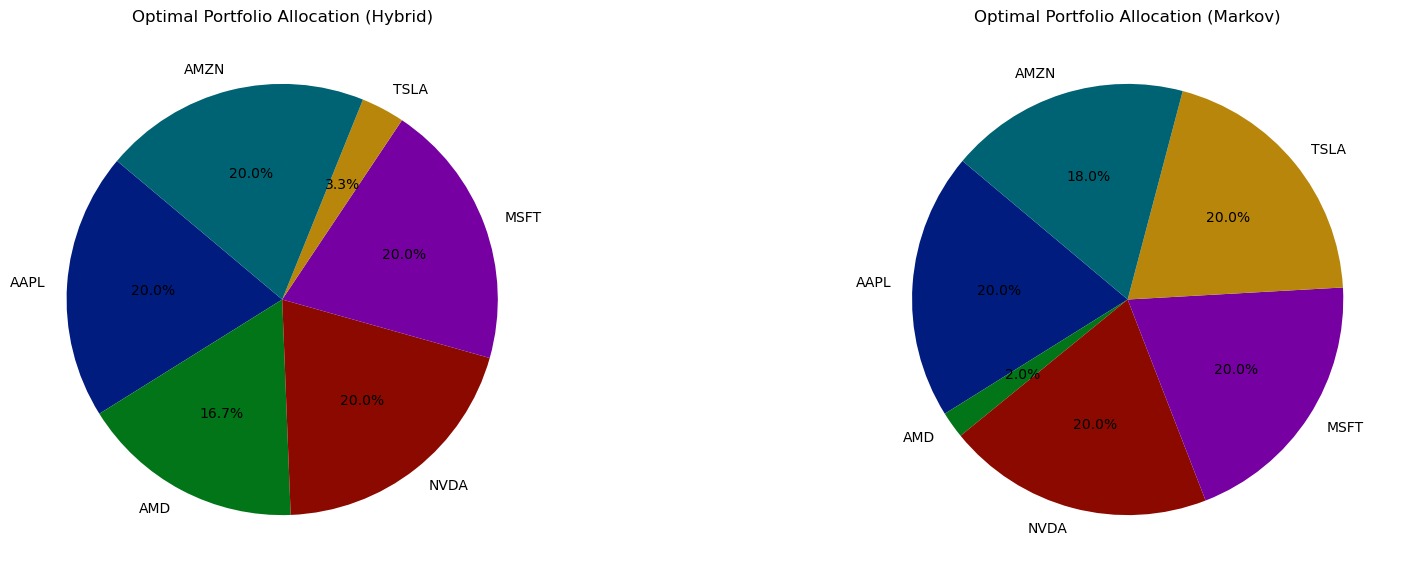

In [18]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot the first pie chart
axes[0].pie(optimal_weights_hybrid, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Optimal Portfolio Allocation (Hybrid)')

# Plot the second pie chart
axes[1].pie(optimal_weights_markov, labels=tickers, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Optimal Portfolio Allocation (Markov)')

# Set the figure and axes background color to white
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')

plt.show() 

#### 10. Comparing returns after 10 days for both portfolios

In [19]:
print('End date : ',end_date)
end_date_str = datetime.strptime(end_date, '%Y-%m-%d')
next_day = end_date_str + timedelta(days=10)
next_day_str = next_day.strftime('%Y-%m-%d')
print('Next day : ',next_day) 

End date :  2019-12-30
Next day :  2020-01-09 00:00:00


In [20]:
data_next = pd.DataFrame()
data_next = yf.download(tickers,start='2019-12-30', end='2020-01-09')['Adj Close'] 
data_next.head(3)     

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,AMD,AMZN,MSFT,NVDA,TSLA
Date,,,,,,
2019-12-30,70.815498,45.520000,92.344498,151.306442,5.784647,27.646667
2019-12-31,71.332916,45.860001,92.391998,151.412109,5.858847,27.888666
2020-01-02,72.960457,49.099998,94.900497,154.215683,5.973634,28.684000


#### 11. Hybrid Model

In [21]:
df_hybrid = pd.DataFrame(index=tickers) 

df_hybrid['Day1'] = data_next.iloc[0].values
df_hybrid['Day10'] = data_next.iloc[-1].values

optimal_weights_hybrid_dict = dict(zip(tickers, optimal_weights_hybrid)) 
df_hybrid['Optimal Weights Hybrid (%)'] = (df_hybrid.index.map(optimal_weights_hybrid_dict)).round(6)

df_hybrid['Day1_values'] = df_hybrid['Day1']*df_hybrid['Optimal Weights Hybrid (%)']
df_hybrid['Day10_values'] = df_hybrid['Day10']*df_hybrid['Optimal Weights Hybrid (%)']

df_hybrid['VaR (per $)'] = df_hybrid.index.map(VaR_df['VaR (per $)']) 
df_hybrid['VaR'] = df_hybrid['Day10_values']*df_hybrid['VaR (per $)'] 

df_hybrid  

,Day1,Day10,Optimal Weights Hybrid (%),Day1_values,Day10_values,VaR (per $),VaR
AAPL,70.815498,73.650352,0.200000,14.163100,14.730070,0.03,0.441902
AMD,45.520000,47.830002,0.167375,7.618910,8.005547,0.06,0.480333
NVDA,92.344498,94.598503,0.200000,18.468900,18.919701,0.04,0.756788
MSFT,151.306442,153.706802,0.200000,30.261288,30.741360,0.02,0.614827
TSLA,5.784647,5.985336,0.032625,0.188724,0.195272,0.05,0.009764
AMZN,27.646667,32.809334,0.200000,5.529333,6.561867,0.03,0.196856


Calculating Total Portfolio value 

In [22]:
total_value_yesterday_hybrid = np.sum(df_hybrid['Day1_values'])
total_value_today_hybrid = np.sum(df_hybrid['Day10_values']) 
total_var_hybrid = np.sum(df_hybrid['VaR']) 

portfolio_return_hybrid = (total_value_today_hybrid - total_value_yesterday_hybrid) / total_value_yesterday_hybrid

print(f"Total Portfolio Value Day1: ${total_value_yesterday_hybrid:.2f}")
print(f"Total Portfolio Value Day10: ${total_value_today_hybrid:.2f}")
print(f'Total VaR : ${total_var_hybrid:.2f}')
print(f"Portfolio Return: {portfolio_return_hybrid:.4f} or {portfolio_return_hybrid * 100:.2f}%") 

Total Portfolio Value Day1: $76.23
Total Portfolio Value Day10: $79.15
Total VaR : $2.50
Portfolio Return: 0.0384 or 3.84%


#### 12. Markov Model

In [23]:
df_markov = pd.DataFrame(index=tickers) 

df_markov['Day1'] = data_next.iloc[0].values
df_markov['Day10'] = data_next.iloc[-1].values

optimal_weights_markov_dict = dict(zip(tickers, optimal_weights_markov))
df_markov['Optimal Weights Markov (%)'] = df_markov.index.map(optimal_weights_markov_dict)

df_markov['Day1_values'] = df_markov['Day1']*df_markov['Optimal Weights Markov (%)']
df_markov['Day10_values'] = df_markov['Day10']*df_markov['Optimal Weights Markov (%)']

df_markov['VaR (per $)'] = df_markov.index.map(VaR_df['VaR (per $)']) 
df_markov['VaR'] = df_markov['Day10_values']*df_markov['VaR (per $)'] 

df_markov  

,Day1,Day10,Optimal Weights Markov (%),Day1_values,Day10_values,VaR (per $),VaR
AAPL,70.815498,73.650352,0.20,14.163100,14.730070,0.03,0.441902
AMD,45.520000,47.830002,0.02,0.910400,0.956600,0.06,0.057396
NVDA,92.344498,94.598503,0.20,18.468900,18.919701,0.04,0.756788
MSFT,151.306442,153.706802,0.20,30.261288,30.741360,0.02,0.614827
TSLA,5.784647,5.985336,0.20,1.156929,1.197067,0.05,0.059853
AMZN,27.646667,32.809334,0.18,4.976400,5.905680,0.03,0.177170


In [24]:
total_value_yesterday_mark = np.sum(df_markov['Day1_values'])
total_value_today_mark = np.sum(df_markov['Day10_values']) 
total_var_mark = np.sum(df_markov['VaR']) 

portfolio_return_markov = (total_value_today_mark - total_value_yesterday_mark) / total_value_yesterday_mark

print(f"Total Portfolio Value Day1: ${total_value_yesterday_mark:.2f}")
print(f"Total Portfolio Value Day10: ${total_value_today_mark:.2f}")
print(f'Total VaR : ${total_var_mark:.2f}')
print(f"Portfolio Return: {portfolio_return_markov:.4f} or {portfolio_return_markov * 100:.2f}%")  

Total Portfolio Value Day1: $69.94
Total Portfolio Value Day10: $72.45
Total VaR : $2.11
Portfolio Return: 0.0359 or 3.59%


#### Calculate the value of portfolio after 10 days

In [25]:
print('='*20,'Comparing Returns and VaR after 10 days','='*20)
print() 
print(f'Returns from Markov Model : {portfolio_return_markov*100:.2f}%')
print(f'VaR for Markov Model : ${total_var_mark:.2f}')
print()
print(f'Returns from Hybrid Model : {portfolio_return_hybrid*100:.2f}%')  
print(f'VaR for Hybrid Model : ${total_var_hybrid:.2f}') 

==================== Comparing Returns and VaR after 10 days ====================

Returns from Markov Model : 3.59%
VaR for Markov Model : $2.11

Returns from Hybrid Model : 3.84%
VaR for Hybrid Model : $2.50
